In [25]:
import random
import pandas as pd
import numpy as np
import os
import copy

In [26]:
import igraph as ig

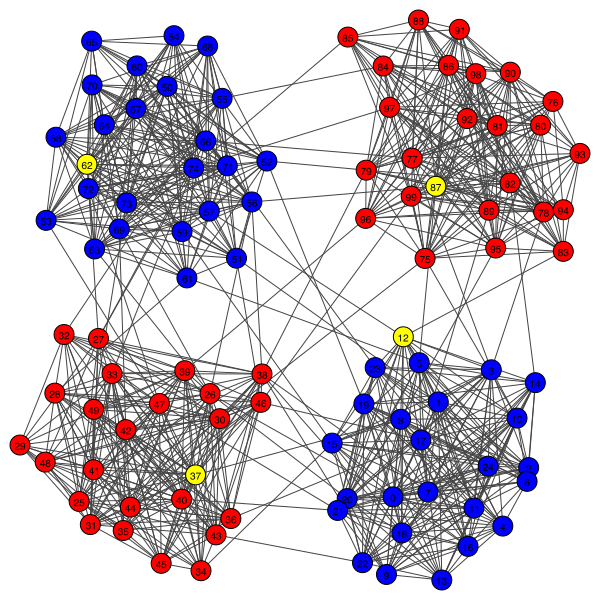

In [27]:
random.seed(42)
np.random.seed(42)
# Number of nodes in each group.

N_community = 4
community_size = 25
N_nodes = N_community * community_size

g = [community_size for _ in range(N_community)]

total_pop = 5000
# Percent of the majority group overall in the population.
maj_pop_pct = 0.7
# Percent of the majority group in the group-dominant nodes.
maj_pop_pct_in_nodes = [0.8]
# probability of in-community and out-community edges
p_in = 0.7
p_out = 0.01

# Capacity of facilities - constant for each facility.
facility_cap = 0.5*total_pop

network_name = f"SBMC_{N_community}_{community_size}_{maj_pop_pct}_{maj_pop_pct_in_nodes}"

if not os.path.exists(network_name):
        os.makedirs(network_name)

# Create NxN matrix of probabilities for in edges and out edges for each community
in_out_prefs = np.full((N_community, N_community), p_out)
np.fill_diagonal(in_out_prefs, p_in)

for i in range(N_community):
    n1 = (i + 1) if (i + 1) < N_community else 0
    n2 = (i - 1) if (i - 1) >= 0 else (N_community - 1)
    in_out_prefs[i][n1] = p_out
    in_out_prefs[i][n2] = p_out

graph = ig.Graph.SBM(N_nodes, in_out_prefs.tolist(), g)
# Raw graph, without any node attributes.
graph_raw = copy.deepcopy(graph)

graph.vs['label'] = graph.vs.indices
graph.vs['label_size'] = 10

colors = ['blue', 'red']
g0 = []
g1 = []
groups = [g0, g1]

idx_end = np.cumsum(g)
idx_start = [0] + [x for x in idx_end][:-1]

fac_nodes = []

for idx in range(len(idx_start)):
    fac_nodes.append(int((idx_start[idx] + idx_end[idx])/2))
    for i in range(idx_start[idx], idx_end[idx]):
        graph.vs[i]['color'] = colors[idx % 2]
        groups[idx % 2].append(i)
        if i in fac_nodes:
            graph.vs[i]['color'] = 'yellow'




ig.plot(graph, vertex_size=20, target=f'./{network_name}/network.pdf')
ig.write(graph, f'./{network_name}/network.gml')
ig.write(graph_raw, f'./{network_name}/network_raw.gml')

# fig, ax = plt.subplots(figsize=(5, 5))
# ax.hist(graph.degree())
# fig.suptitle('Degree distrubtion')
# fig.savefig(f'./{network_name}_degree_distribution.png')

# fig, ax = plt.subplots(figsize=(5, 5))
# ax.hist(graph.closeness())
# fig.suptitle('Closeness distrubtion')
# fig.savefig(f'./{network_name}_closeness_distribution.png')
ig.plot(graph, vertex_size=20)

In [22]:
np.random.seed(42)
graph = ig.Graph.Read(f'./{network_name}/network.gml')
nodes = pd.DataFrame({attr: graph.vs[attr] for attr in graph.vertex_attributes()})
nodes['id'] = nodes['id'].astype(int)
nodes.loc[:, 'closeness'] = graph.closeness()

nodes.loc[nodes['id'].isin(g0), 'g0_pct'] = np.random.choice(maj_pop_pct_in_nodes, len(g0))
nodes.loc[nodes['id'].isin(g0), 'g1_pct'] = 1 - nodes.loc[nodes['id'].isin(g0), 'g0_pct']

nodes.loc[nodes['g0_pct'].isna(), 'g1_pct'] = np.random.choice(maj_pop_pct_in_nodes, len(g1))
nodes.loc[nodes['g0_pct'].isna(), 'g0_pct'] = 1 - nodes.loc[nodes['g0_pct'].isna(), 'g1_pct']

# Group distribution on nodes. The percentage of each group in each node.
nodes.loc[:, 'g0_in_node'] = nodes['g0_pct'] / nodes['g0_pct'].sum()
nodes.loc[:, 'g1_in_node'] = nodes['g1_pct'] / nodes['g1_pct'].sum()

In [23]:
# Generate Population of agents for each node in the network.
agents = []
g0_nr = int(total_pop * maj_pop_pct)
g1_nr = total_pop - g0_nr

# id = 0
for i in range(total_pop):
    group = 'g0' if i < g0_nr else 'g1'
    node = np.random.choice(nodes['id'], p=nodes[f'{group}_in_node'])
    # Set tolerance similar to that of the majority population of the node.
    agents.append({'id': i, 'node': node, 'group': group,
                   'tolerance': nodes[nodes['id'] == node][['g0_pct', 'g1_pct']].iloc[0].max()})

agents = pd.DataFrame(agents)
agents.to_csv(f'./{network_name}/population.csv', index=False)

# # Adjust nodes to include the number of agents in each group and the real percentage of each group in the node.
agents_per_node = agents.groupby(['node', 'group'])['id'].count().unstack() \
    .rename(columns={'g0': 'g0_nr', 'g1': 'g1_nr'}) \
    .fillna(0).astype(int)
nodes = nodes.merge(agents_per_node, how='left', left_on='id', right_on='node')
nodes.loc[:, 'g0_pct'] = nodes['g0_nr'] / (nodes['g0_nr'] + nodes['g1_nr'])
nodes.loc[:, 'g1_pct'] = nodes['g1_nr'] / (nodes['g0_nr'] + nodes['g1_nr'])
nodes.loc[:, 'g0_in_node'] = nodes['g0_nr'] / nodes['g0_nr'].sum()
nodes.loc[:, 'g1_in_node'] = nodes['g1_nr'] / nodes['g1_nr'].sum()

In [24]:
facility_cap = total_pop // len(fac_nodes)

facilities = []
for i, f in enumerate(fac_nodes):
    facilities.append(
        {'id': i, 'node': f, 'facility': f'school_{i}', 'capacity': facility_cap, 'quality': 0.5, 'popularity': 0.5})

facilities = pd.DataFrame(facilities)

facilities.to_csv(f'./{network_name}/facilities.csv', index=False)

# %% Dissimilaritiy index of population in the network

A = nodes['g0_nr'].sum()
B = nodes['g1_nr'].sum()
DI = 0
for _, nid in nodes.iterrows():
    a = nid['g0_nr']
    b = nid['g1_nr']

    DI += np.abs(a / A - b / B)

print(f'Dissimilarity Index: {1 / 2 * DI}')

Dissimilarity Index: 0.5919047619047618
